# Python for Linguists module 1.4

Welcome to module 1.4. In this module, we will start calculating statistics using real corpus. 

Let's first refresh your memory on ngrams and probabilities by completing the following quiz:

## Pre-module quiz

Given the sequence 'aabbdab', what is *P*(b|a)?

A. 1/2

B. 1/3

C. 1

D. 0

The correct answer is B. 

## Importing packages

In [61]:
#For tokenization of a sentence
# Create a Tokenizer with the default settings for English
# including punctuation rules and exceptions
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
nlp = English() 
tokenizer = nlp.Defaults.create_tokenizer(nlp)

str

## Processing the corpora

We will be using the Shakespeare corpus. The relative path to the corpus file is ../../corpora/shakespeare (.. indicates the parent directory). 
Let's first load the corpus by using the open function:

In [66]:
f=open('../../corpora/Shakespeare','r')

We declared the variable f to open the Shakespeare file. Open takes 2 arguments, the path to the file that we want to open and a string that represents the kinds of permission or operation we want to do on the file. Here 'r' refers to the permission of 'read-only'. 

Let's first import spac for tokenization:

In [ ]:
# Create a Tokenizer with the default settings for English
# including punctuation rules and exceptions
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
nlp = English() 
tokenizer = nlp.Defaults.create_tokenizer(nlp)

Let's write a for loop to process each line of the file and store the processed lines as tokenized word lists into another variable

In [67]:
f_processed=[] # a list to store the processed lines
for line in f:
    #for each line, we do:
    #1. remove control characters like \t \r \n
    line=line.strip()
    #2. skip the empty lines
    if line=='':
        continue
    else: 
        #3. tokenize the sentence into word list:
        tokens =[str(tok) for tok in tokenizer(line)]# tokens are now a list of words for the current line
        f_processed.append(tokens)

## Counting Vocabulary

Now let's loop over the word lists in f_processed to create a vocabulary dictionary:

In [69]:
vocab={}# create a vocabulary dictionary where key is the word and value is the count
for line in f_processed:
    for word in line:
        if word in vocab:
            vocab[word]+=1 # update the count for an existing word
        else:
            vocab[word]=1 # initilize the count for a new word


### Practice quiz 1:
What is the count of the word 'book' in the corpus?


In [71]:
vocab['book']

101

## Caluating Type-token ratio

Let's calculate type count first:

In [73]:
type_count=len(vocab.keys())
print (type_count)

32951


Let's caculate token count:

In [75]:
# Let's create a loop to aggregate the token counts in the vocabulary:
token_count=0
for word in vocab:
    token_count+=vocab[word]
print (token_count)


1133110


In [77]:
#Let's calculate the type-token ratio:
ttr=type_count/token_count
print (ttr)

0.029080142263328362


Alternatively, we could wrap the calculation up into a function that takes in vocab dictionary and outputs the ttr

In [79]:
def ttr_cal(vocab):
    type_count=len(vocab.keys())
    token_count=0
    for word in vocab:
        token_count+=vocab[word]
    ttr=type_count/token_count
    return ttr

In [80]:
print (ttr_cal(vocab))

0.029080142263328362


## Plotting a frequency distribution

Let's first import matplotlib for plotting

In [92]:
import matplotlib.pyplot as plt

Then we can sort the words to get the top-100 frequent words

In [115]:
topn=100
vocab_sorted=sorted(vocab.items(),key=lambda x: x[1],reverse=True)[:topn]


loop through the sorted vocabulary to get words and counts for plotting the graphs


In [ ]:
words=[]
counts=[]
for w_c in vocab_sorted:
    w=w_c[0]
    words.append(w)
    count=w_c[1]
    counts.append(count)


We could now plot a histogram using the words and counts

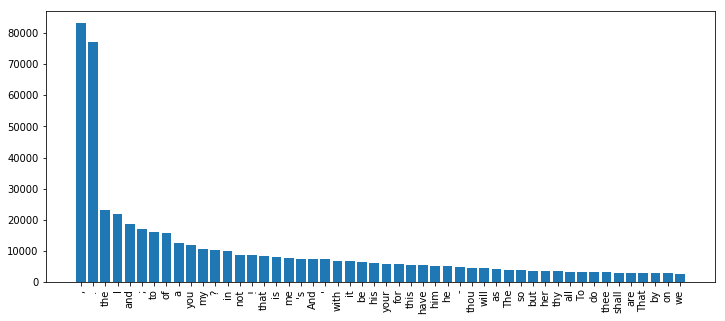

In [114]:
plt.figure(figsize=(12,5)) #figure size
plt.bar(words,counts) #plot the historgram
plt.xticks(rotation=90) # rotate the x label
plt.show()

### Practice quiz 2:
Try changing topn and observe what are the properties of the top-frequent words?


## Counting bigrams

A bigram is a sequence of adjacent two words. Let's create a nested dictionary to store the bigrams. They key will be each bigram and the value will be counts


Let's first loop through the lines in f_processed

In [133]:
bigram_dict={}
for line in f_processed:
    #insert start <start> and end <end> token
    line=['<start>']+line+['<end>']
    for i,w in enumerate(line):
        w_first=w
        if i+1<len(line): #not the end of the line
            w_second=line[i+1]
            bigram=(w_first,w_second) #a tuple to represent bigram
            if bigram not in bigram_dict:
                bigram_dict[bigram]=1
            else:
                bigram_dict[bigram]+=1
                
        

### Practice quiz 3:
What is the count of the bigram 'thank you'?

In [137]:
bigram_dict[('thank','you')]

124